In [54]:
import sys
import os
import yaml
import warnings
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score, adjusted_rand_score,
                             normalized_mutual_info_score, homogeneity_score,
                             completeness_score, v_measure_score)
from scipy.stats import entropy, pearsonr
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import gseapy

warnings.simplefilter("ignore")

### Load Configs

In [60]:
config_path = 'clustering_config.yaml'
if not os.path.exists(config_path):
    raise FileNotFoundError(f"Configuration file not found: {config_path}")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
print(f"Loaded configuration for: {config.get('project_name', 'Unnamed Project')}")

# --- Setup Paths and Settings ---
print("--- Setting up Paths and Scanpy ---")
paths_cfg = config['paths']
output_cfg = config['output_paths']
viz_cfg = config['visualization']
data_keys_cfg = config['data_keys']
pp_cfg = config['preprocessing']
cluster_cfg = config['clustering']
eval_cfg = config['evaluation']
interp_cfg = config['interpretability']
bench_cfg = config['benchmarking']
RANDOM_SEED = config['random_seed']

Loaded configuration for: scBERT_Dataset2_Analysis
--- Setting up Paths and Scanpy ---


In [ ]:
# Create output directories
os.makedirs(output_cfg['adata_embedded_dir'], exist_ok=True)
os.makedirs(output_cfg['adata_clustered_dir'], exist_ok=True)
os.makedirs(output_cfg['scanpy_plots_output'], exist_ok=True)
os.makedirs(output_cfg['autosave_plots_output'], exist_ok=True)
os.makedirs(output_cfg['evaluation_plots_output'], exist_ok=True)
os.makedirs(output_cfg['interpretability_output_dir'], exist_ok=True)
os.makedirs(output_cfg['benchmarking_output_dir'], exist_ok=True)

### Load Data

In [ ]:
adata_path = './output/adata_embedding_mini_dataset.h5ad'
adata = sc.read_h5ad(adata_path)
embeddings = adata.X
print(f'Embeddings dimention : {embeddings.shape}')
model_embedding_key = 'scbert_embed'

Embeddings dimention : (48344, 200)


# Clustering Algorithms

### GMM

--- Running Gaussian Mixture Model (GMM) ---
Calculating BIC/AIC for component selection...
  Fitting GMM with 2 components...
  Fitting GMM with 3 components...
  Fitting GMM with 4 components...
  Fitting GMM with 5 components...
  Fitting GMM with 6 components...
  Fitting GMM with 7 components...
  Fitting GMM with 8 components...
  Fitting GMM with 9 components...
  Fitting GMM with 10 components...
  Fitting GMM with 11 components...
  Fitting GMM with 12 components...
  Fitting GMM with 13 components...
  Fitting GMM with 14 components...
  Fitting GMM with 15 components...
  Fitting GMM with 16 components...
  Fitting GMM with 17 components...
  Fitting GMM with 18 components...
  Fitting GMM with 19 components...
Optimal number of clusters based on BIC: 19


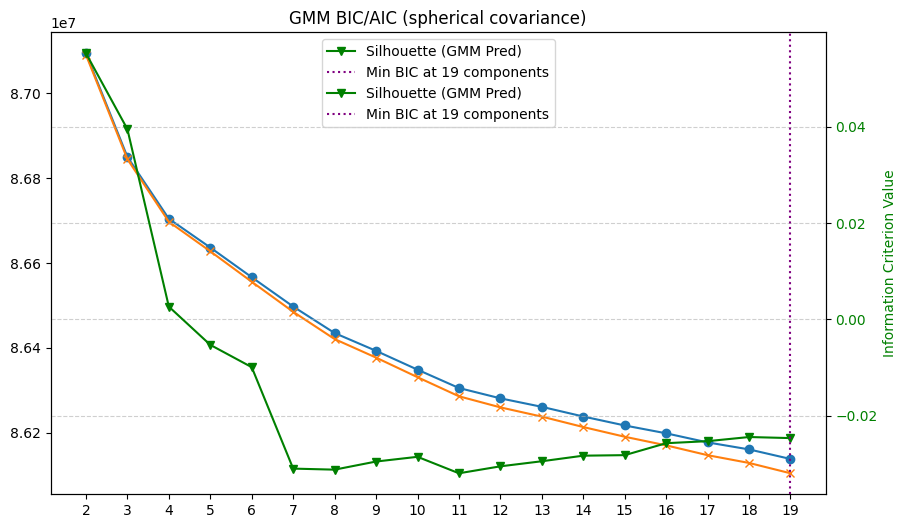

Fitting final GMM with 19 components...
Added 'GMM_probabilities' to obsm, 'GMM_entropy' and 'gmm_cluster' to obs.


In [4]:
# --- Gaussian Mixture Model (GMM) ---
optimal_n_clusters = None
if cluster_cfg['use_gmm']:
    print("--- Running Gaussian Mixture Model (GMM) ---")
    n_components_range = range(cluster_cfg['gmm']['n_components_min'], cluster_cfg['gmm']['n_components_max'])
    bic_scores = []
    aic_scores = []
    silhouette_scores_gmm = [] # GMM silhouette
    covariance_type = cluster_cfg['gmm']['covariance_type']
    gmm_n_init = cluster_cfg['gmm']['n_init']

    print("Calculating BIC/AIC for component selection...")
    for n_components in n_components_range:
        print(f"  Fitting GMM with {n_components} components...")
        gmm_temp = GaussianMixture(n_components=n_components, n_init=gmm_n_init,
                                   covariance_type=covariance_type, random_state=RANDOM_SEED)
        gmm_temp.fit(embeddings)
        bic_scores.append(gmm_temp.bic(embeddings))
        aic_scores.append(gmm_temp.aic(embeddings))
        # Calculate silhouette score for this number of components
        try:
            gmm_pred_labels = gmm_temp.predict(embeddings)
            if len(set(gmm_pred_labels)) > 1: # Silhouette needs > 1 cluster
                 score = silhouette_score(embeddings, gmm_pred_labels, metric='euclidean')
                 silhouette_scores_gmm.append(score)
            else:
                 silhouette_scores_gmm.append(np.nan) # Or handle as needed
        except Exception as e:
             print(f"    Warning: Could not calculate silhouette for {n_components} components: {e}")
             silhouette_scores_gmm.append(np.nan)


    # Plot BIC/AIC
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
    plt.plot(n_components_range, aic_scores, label='AIC', marker='x')
    # Plot Silhouette on secondary axis if calculated
    if not all(np.isnan(silhouette_scores_gmm)):
        ax2 = plt.gca().twinx()
        ax2.plot(n_components_range, silhouette_scores_gmm, label='Silhouette (GMM Pred)', color='green', marker='v')
        ax2.set_ylabel('Silhouette Score', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        # Combine legends
        lines, labels = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='best')
    else:
        plt.legend(loc='best')

    plt.xlabel('Number of Components')
    plt.ylabel('Information Criterion Value')
    plt.title(f'GMM BIC/AIC ({covariance_type} covariance)')
    plt.xticks(list(n_components_range))
    plt.grid(True, linestyle='--', alpha=0.6)

    # Mark minimum BIC
    min_bic_index = np.argmin(bic_scores)
    optimal_n_clusters = n_components_range[min_bic_index]
    plt.axvline(optimal_n_clusters, color='purple', linestyle=':',
                label=f'Min BIC at {optimal_n_clusters} components')
    # Update legend if BIC line was added
    if not all(np.isnan(silhouette_scores_gmm)):
        lines, labels = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        # Find the existing legend and update it
        leg = ax2.get_legend()
        if leg:
            leg.remove() # Remove the old combined legend
        ax2.legend(lines + lines2, labels + labels2, loc='best') # Recreate combined legend
    else:
         plt.legend(loc='best') # Recreate legend if only BIC/AIC

    print(f"Optimal number of clusters based on BIC: {optimal_n_clusters}")
    plt.show() # Uses patched show

    # Fit final GMM
    print(f"Fitting final GMM with {optimal_n_clusters} components...")
    gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=RANDOM_SEED,
                          n_init=gmm_n_init, covariance_type=covariance_type)
    gmm.fit(embeddings)
    gmm_probabilities = gmm.predict_proba(embeddings)
    epsilon = 1e-9 # Add epsilon for numerical stability in entropy calculation
    cell_entropy = entropy(gmm_probabilities.T + epsilon, base=2)
    dominant_cluster = np.argmax(gmm_probabilities, axis=1)

    # Store results
    adata.obsm['GMM_probabilities'] = gmm_probabilities
    adata.obs['GMM_entropy'] = cell_entropy
    gmm_key = 'gmm_cluster'
    adata.obs[gmm_key] = pd.Categorical([f'GMM_{c}' for c in dominant_cluster])
    print(f"Added 'GMM_probabilities' to obsm, 'GMM_entropy' and '{gmm_key}' to obs.")
    if gmm_key not in cluster_cfg['clustering_keys_to_analyze']:
         cluster_cfg['clustering_keys_to_analyze'].append(gmm_key)

### K-Means

In [26]:
# --- K-Means Clustering ---
if cluster_cfg['use_kmeans']:
    if optimal_n_clusters is None:
        warnings.warn("Cannot run KMeans without an optimal cluster number from GMM (or specify manually). Skipping KMeans.")
    else:
        print(f"\n--- Running K-Means Clustering (k={optimal_n_clusters}) ---")
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=RANDOM_SEED, n_init=cluster_cfg['kmeans']['n_init'])
        kmeans_labels = kmeans.fit_predict(embeddings)
        kmeans_key = 'kmeans'
        adata.obs[kmeans_key] = pd.Categorical([f'KMeans_{c}' for c in kmeans_labels])
        print(f"Stored K-Means results in adata.obs['{kmeans_key}']")
        if kmeans_key not in cluster_cfg['clustering_keys_to_analyze']:
             cluster_cfg['clustering_keys_to_analyze'].append(kmeans_key)


--- Running K-Means Clustering (k=19) ---
Stored K-Means results in adata.obs['kmeans']


### Leiden

In [ ]:
#if no neighbors or umap in adata
sc.pp.neighbors(adata, use_rep=model_embedding_key, n_neighbors=pp_cfg['n_neighbors'], random_state=RANDOM_SEED)
umap_key = viz_cfg['embedding_basis'] # e.g., "X_umap_cancerfnd"
sc.tl.umap(adata, random_state=RANDOM_SEED, neighbors_key=None) # Use default neighbors calculation
# Rename the default 'X_umap' to our specific key
if 'X_umap' in adata.obsm_keys():
    adata.obsm[umap_key] = adata.obsm['X_umap']
    del adata.obsm['X_umap']
    print(f"UMAP calculated and stored in adata.obsm['{umap_key}']")
else:
     warnings.warn("sc.tl.umap did not produce 'X_umap' as expected.")

In [30]:
# --- Leiden Clustering ---
if cluster_cfg['use_leiden']:
    print("\n--- Running Leiden Clustering ---")
    leiden_key = 'leiden'
    sc.tl.leiden(adata, resolution=cluster_cfg['leiden']['resolution'],
                 random_state=RANDOM_SEED, key_added=leiden_key, neighbors_key=None) # Use default neighbors
    print(f"Stored Leiden results in adata.obs['{leiden_key}']")
    print(f"Found {len(adata.obs[leiden_key].cat.categories)} Leiden clusters.")
    if leiden_key not in cluster_cfg['clustering_keys_to_analyze']:
        cluster_cfg['clustering_keys_to_analyze'].append(leiden_key)


--- Running Leiden Clustering ---
Stored Leiden results in adata.obs['leiden']
Found 19 Leiden clusters.


### Louvain

In [31]:
# --- Louvain Clustering ---
if cluster_cfg['use_louvain']:
    print("\n--- Running Louvain Clustering ---")
    louvain_key = 'louvain'
    sc.pp.neighbors(adata, use_rep='X', n_neighbors=pp_cfg['n_neighbors'], random_state=RANDOM_SEED)

    sc.tl.louvain(adata, resolution=cluster_cfg['louvain']['resolution'],
                  random_state=RANDOM_SEED, key_added=louvain_key, neighbors_key=None) # Use default neighbors
    print(f"Stored Louvain results in adata.obs['{louvain_key}']")
    print(f"Found {len(adata.obs[louvain_key].cat.categories)} Louvain clusters.")
    if louvain_key not in cluster_cfg['clustering_keys_to_analyze']:
        cluster_cfg['clustering_keys_to_analyze'].append(louvain_key)


--- Running Louvain Clustering ---
Stored Louvain results in adata.obs['louvain']
Found 18 Louvain clusters.


# Visualization

Plotting UMAPs based on 'X_umap_scBERT'...
Plotting UMAP colored by 'cell_state'...


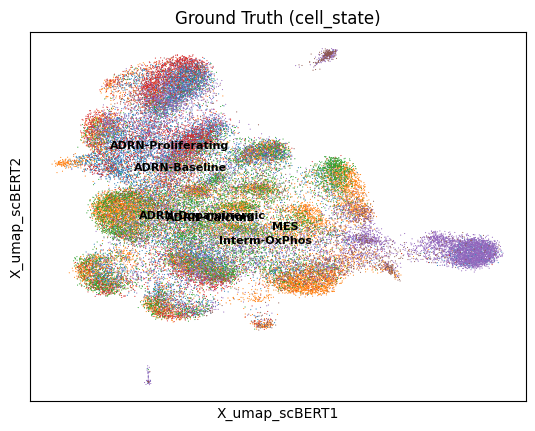

Plotting UMAP colored by 'donor_id'...


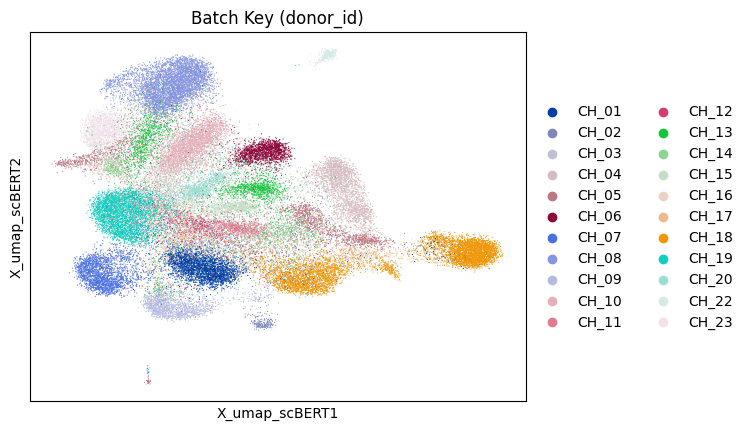

Plotting UMAP colored by 'Stage_Code'...


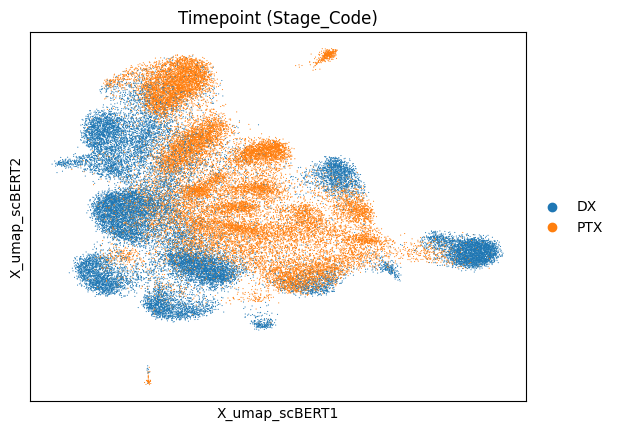

Plotting UMAP colored by 'leiden'...


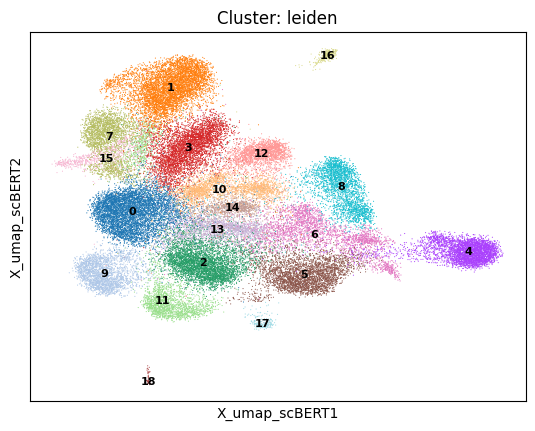

Plotting UMAP colored by 'louvain'...


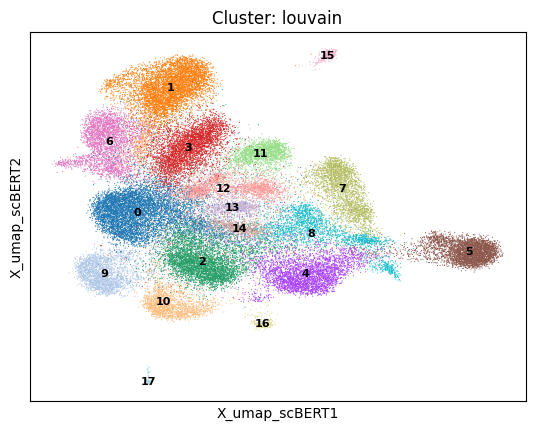

Plotting UMAP colored by 'gmm_cluster'...


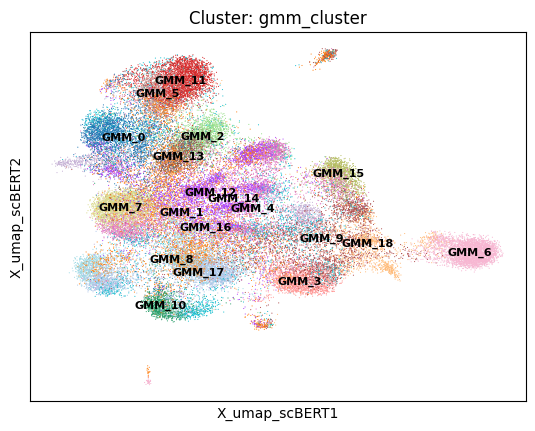

Plotting UMAP colored by 'kmeans'...


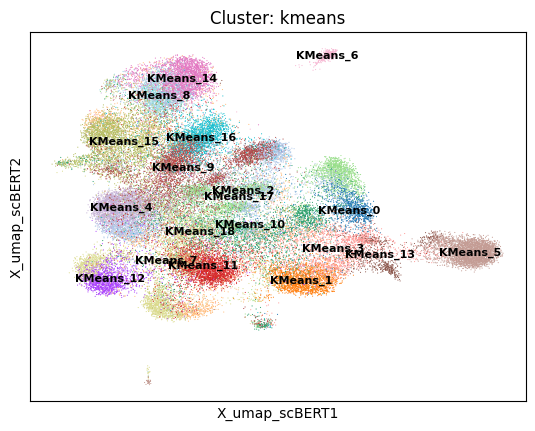

Plotting UMAP colored by GMM Entropy...


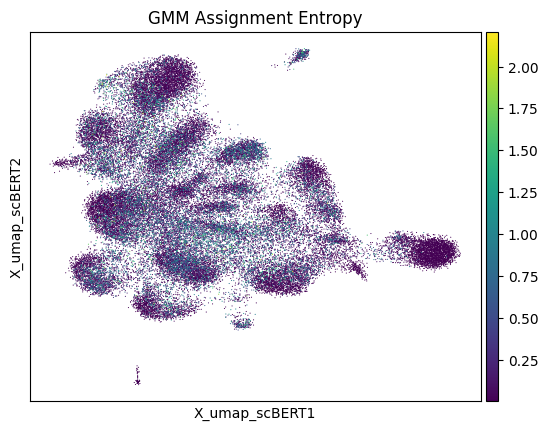

In [36]:
umap_key = viz_cfg['embedding_basis']
if umap_key not in adata.obsm:
    warnings.warn(f"UMAP key '{umap_key}' not found. Skipping UMAP plots.")
else:
    print(f"Plotting UMAPs based on '{umap_key}'...")

    # Plot by Ground Truth
    if data_keys_cfg['ground_truth_key'] in adata.obs:
        print(f"Plotting UMAP colored by '{data_keys_cfg['ground_truth_key']}'...")
        sc.pl.embedding(adata, basis=umap_key, color=data_keys_cfg['ground_truth_key'],
                       legend_loc='on data', legend_fontsize=8, title=f'Ground Truth ({data_keys_cfg["ground_truth_key"]})')
        plt.show()
    else:
        print(f"Skipping ground truth UMAP plot: key '{data_keys_cfg['ground_truth_key']}' not found.")

    # Plot by Batch Key
    if data_keys_cfg['batch_key'] in adata.obs:
        print(f"Plotting UMAP colored by '{data_keys_cfg['batch_key']}'...")
        sc.pl.embedding(adata, basis=umap_key, color=data_keys_cfg['batch_key'],
                       title=f'Batch Key ({data_keys_cfg["batch_key"]})')
        plt.show()
    else:
        print(f"Skipping batch key UMAP plot: key '{data_keys_cfg['batch_key']}' not found.")

    # Plot by Timepoint Key
    if data_keys_cfg['timepoint_key'] in adata.obs:
        print(f"Plotting UMAP colored by '{data_keys_cfg['timepoint_key']}'...")
        sc.pl.embedding(adata, basis=umap_key, color=data_keys_cfg['timepoint_key'],
                       title=f'Timepoint ({data_keys_cfg["timepoint_key"]})')
        plt.show()
    else:
        print(f"Skipping timepoint key UMAP plot: key '{data_keys_cfg['timepoint_key']}' not found.")


    # Plot by Generated Clusters
    for cluster_key in cluster_cfg['clustering_keys_to_analyze']:
        if cluster_key in adata.obs:
            print(f"Plotting UMAP colored by '{cluster_key}'...")
            sc.pl.embedding(adata, basis=umap_key, color=cluster_key,
                           legend_loc='on data', legend_fontsize=8, title=f'Cluster: {cluster_key}')
            plt.show()
        else:
            print(f"Skipping cluster UMAP plot: key '{cluster_key}' not found.")

    # Plot GMM Entropy if available
    if 'GMM_entropy' in adata.obs:
        print("Plotting UMAP colored by GMM Entropy...")
        sc.pl.embedding(adata, basis=umap_key, color='GMM_entropy', cmap='viridis',
                       title='GMM Assignment Entropy')
        plt.show()

# Evaluation

In [41]:
ground_truth_key = data_keys_cfg['ground_truth_key']
if ground_truth_key not in adata.obs.columns:
    warnings.warn(f"Ground truth key '{ground_truth_key}' not found. Skipping evaluation.")
else:
    true_labels = adata.obs[ground_truth_key]
    # Ensure categorical for consistent plotting/indexing
    if not pd.api.types.is_categorical_dtype(true_labels):
        true_labels = true_labels.astype('category')
    true_label_names = true_labels.cat.categories

    metrics_results = {}
    valid_clustering_keys_for_eval = []

    # --- Calculate Metrics ---
    print("--- 1. Calculating Evaluation Metrics ---")
    for key in cluster_cfg['clustering_keys_to_analyze']:
        if key in adata.obs.columns:
            valid_clustering_keys_for_eval.append(key)
            print(f"Evaluating: {key}")
            predicted_labels = adata.obs[key]
            ari = adjusted_rand_score(true_labels, predicted_labels)
            nmi = normalized_mutual_info_score(true_labels, predicted_labels)
            homogeneity = homogeneity_score(true_labels, predicted_labels)
            completeness = completeness_score(true_labels, predicted_labels)
            v_measure = v_measure_score(true_labels, predicted_labels)

            # Silhouette Score (on the embedding used for clustering)
            silhouette = np.nan
            try:
                 # Ensure predicted labels are suitable (e.g., integers or strings)
                 # If categorical, get codes; otherwise, assume suitable format
                 if pd.api.types.is_categorical_dtype(predicted_labels):
                     pred_numeric = predicted_labels.cat.codes
                 else:
                     # Attempt conversion if needed, handle errors gracefully
                     try:
                         pred_numeric = pd.to_numeric(predicted_labels, errors='coerce')
                         if pred_numeric.isnull().any():
                             # If conversion fails or introduces NaNs, try factorize
                             pred_numeric, _ = pd.factorize(predicted_labels)
                     except:
                         pred_numeric, _ = pd.factorize(predicted_labels)

                 # Check for noise labels (e.g., -1 in HDBSCAN/OPTICS) - exclude if present?
                 # Or calculate silhouette only on clustered points. For now, include all.
                 if len(set(pred_numeric)) > 1: # Need at least 2 clusters
                     silhouette = silhouette_score(embeddings, pred_numeric, metric='euclidean')
                 else:
                     print(f"  Skipping Silhouette for {key}: Only one cluster found.")
            except Exception as e:
                 print(f"  Warning: Could not calculate Silhouette score for {key}: {e}")


            metrics_results[key] = {'ARI': ari, 'NMI': nmi, 'Homogeneity': homogeneity,
                                    'Completeness': completeness, 'V-Measure': v_measure,
                                    'Silhouette': silhouette}
            print(f"  ARI: {ari:.4f}, NMI: {nmi:.4f}, Homogeneity: {homogeneity:.4f}, Completeness: {completeness:.4f}, V-Measure: {v_measure:.4f}, Silhouette: {silhouette:.4f}")
        else:
            print(f"Skipping evaluation for {key}: Key not found in adata.obs")

    if metrics_results:
        metrics_df = pd.DataFrame(metrics_results).T
        print("\n--- Metrics Summary ---")
        print(metrics_df.to_markdown(floatfmt=".4f"))
        print("-" * 25)
        metrics_output_path = os.path.join(output_cfg['evaluation_plots_output'], 'clustering_metrics.csv')
        metrics_df.to_csv(metrics_output_path)
        print(f"Metrics saved to {metrics_output_path}")
    else:
        print("No valid clustering keys found to evaluate.")


    # --- Confusion Matrices ---
    print("\n--- 2. Generating Confusion Matrices ---")
    for key in valid_clustering_keys_for_eval:
        print(f"Generating Confusion Matrix for: {key}")
        predicted_labels = adata.obs[key]
        if not pd.api.types.is_categorical_dtype(predicted_labels):
            predicted_labels = predicted_labels.astype('category')
        predicted_label_names = predicted_labels.cat.categories

        cm_df = pd.crosstab(true_labels, predicted_labels, rownames=[f'True ({ground_truth_key})'], colnames=[f'Predicted ({key})'])
        # Ensure all categories are present
        cm_df = cm_df.reindex(index=true_label_names, columns=predicted_label_names, fill_value=0)

        # Dynamic figure size and annotation size
        fig_width = max(8, len(predicted_label_names) * 0.5 + 2)
        fig_height = max(6, len(true_label_names) * 0.4 + 2)
        annotation_size = max(6, 12 - max(len(predicted_label_names), len(true_label_names)) // 3)

        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=.5, annot_kws={"size": annotation_size})
        plt.title(f'Confusion Matrix: {key} vs {ground_truth_key}')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        # Save explicitly in this section for clarity
        cm_fig_path = os.path.join(output_cfg['evaluation_plots_output'], f'confusion_matrix_{key}_vs_{ground_truth_key}.png')
        plt.savefig(cm_fig_path, dpi=viz_cfg['figure_dpi'])
        plt.close() # Close after saving
        print(f"Saved confusion matrix to {cm_fig_path}")


    # --- Cluster Composition Bar Plots ---
    print(f"\n--- 3. Generating Cluster Composition Plots ---")
    try:
        # Use a perceptually uniform colormap if many categories, or tab20 if fewer
        if len(true_label_names) > 20:
             colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(true_label_names)))
        else:
             colors = plt.get_cmap('tab20').colors
    except ValueError:
        colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(true_label_names))) # Fallback


    for key in valid_clustering_keys_for_eval:
        print(f"Generating Composition Plot for: {key}")
        ct = pd.crosstab(adata.obs[key], true_labels)
        # Normalize by predicted cluster (rows sum to 1)
        ct_norm = ct.apply(lambda x: x / x.sum(), axis=1)

        ax = ct_norm.plot(kind='bar', stacked=True, figsize=(max(10, len(ct_norm.index)*0.5), 7),
                          color=colors[:len(true_label_names)])

        plt.title(f'Composition of {key} Clusters by {ground_truth_key} Labels')
        plt.xlabel(f'Predicted Cluster ({key})')
        plt.ylabel('Proportion of Cells')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title=ground_truth_key, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
        plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust rect to make space for legend

        comp_fig_path = os.path.join(output_cfg['evaluation_plots_output'], f'composition_plot_{key}.png')
        plt.savefig(comp_fig_path, dpi=viz_cfg['figure_dpi'])
        plt.close()
        print(f"Saved composition plot to {comp_fig_path}")

--- 1. Calculating Evaluation Metrics ---
Evaluating: leiden
  ARI: 0.0565, NMI: 0.1148, Homogeneity: 0.1503, Completeness: 0.0929, V-Measure: 0.1148, Silhouette: 0.0085
Evaluating: louvain
  ARI: 0.0570, NMI: 0.1136, Homogeneity: 0.1460, Completeness: 0.0929, V-Measure: 0.1136, Silhouette: 0.0088
Evaluating: gmm_cluster
  ARI: 0.0669, NMI: 0.1575, Homogeneity: 0.2117, Completeness: 0.1254, V-Measure: 0.1575, Silhouette: -0.0246
Evaluating: kmeans
  ARI: 0.0643, NMI: 0.1425, Homogeneity: 0.1919, Completeness: 0.1134, V-Measure: 0.1425, Silhouette: -0.0144

--- Metrics Summary ---
|             |    ARI |    NMI |   Homogeneity |   Completeness |   V-Measure |   Silhouette |
|:------------|-------:|-------:|--------------:|---------------:|------------:|-------------:|
| leiden      | 0.0565 | 0.1148 |        0.1503 |         0.0929 |      0.1148 |       0.0085 |
| louvain     | 0.0570 | 0.1136 |        0.1460 |         0.0929 |      0.1136 |       0.0088 |
| gmm_cluster | 0.0669 | 0.15

In [57]:
interp_dir = output_cfg['interpretability_output_dir']
timepoint_key = data_keys_cfg['timepoint_key']
timepoint_pre = data_keys_cfg['timepoint_pre']
timepoint_post = data_keys_cfg['timepoint_post']

if not interp_cfg['correlate_dims_with_timepoint'] and not interp_cfg['perform_deg_analysis']:
     print("Skipping interpretability analysis as configured.")
elif model_embedding_key not in adata.obsm:
     print(f"Skipping interpretability: Embedding key '{model_embedding_key}' not found.")
elif timepoint_key not in adata.obs:
     print(f"Skipping interpretability: Timepoint key '{timepoint_key}' not found.")
else:
    latent_dims = adata.obsm[model_embedding_key]
    n_dims = latent_dims.shape[1]
    dim_correlations = {}
    top_dims_info = [] # Store info about top correlated dimensions

    # --- Correlate Latent Dims with Timepoint ---
    if interp_cfg['correlate_dims_with_timepoint']:
        print(f"--- Correlating {n_dims} Latent Dimensions with Timepoint ({timepoint_key}) ---")
        if timepoint_pre not in adata.obs[timepoint_key].unique() or \
           timepoint_post not in adata.obs[timepoint_key].unique():
            warnings.warn(f"Cannot perform correlation: One or both timepoints ('{timepoint_pre}', '{timepoint_post}') not found in '{timepoint_key}'.")
        else:
            # Create numerical representation of timepoint
            timepoint_numeric = adata.obs[timepoint_key].map({timepoint_pre: 0, timepoint_post: 1})
            # Keep only non-NaN values (cells belonging to pre or post)
            valid_idx = timepoint_numeric.notna()
            if valid_idx.sum() < 2:
                 warnings.warn("Not enough valid timepoint data points for correlation.")
            else:
                latent_dims_valid = latent_dims[valid_idx]
                timepoint_numeric_valid = timepoint_numeric[valid_idx]

                corrs = []
                pvals = []
                for i in range(n_dims):
                    # Ensure the latent dim values are also valid numbers
                    dim_values = latent_dims_valid[:, i]
                    if np.isnan(dim_values).any() or np.isinf(dim_values).any():
                        corrs.append(np.nan)
                        pvals.append(np.nan)
                        warnings.warn(f"NaN or Inf found in latent dimension {i}, skipping correlation.")
                        continue

                    try:
                         corr, pval = pearsonr(dim_values, timepoint_numeric_valid)
                         corrs.append(corr)
                         pvals.append(pval)
                    except ValueError as e:
                         warnings.warn(f"Could not calculate correlation for dimension {i}: {e}")
                         corrs.append(np.nan)
                         pvals.append(np.nan)


                dim_correlations = pd.DataFrame({
                    'Dimension': range(n_dims),
                    'Correlation': corrs,
                    'PValue': pvals,
                    'AbsCorrelation': np.abs(corrs)
                }).sort_values('AbsCorrelation', ascending=False).reset_index(drop=True)

                print("\nTop Latent Dimensions Correlated with Timepoint:")
                print(dim_correlations.head(interp_cfg['n_top_dims']).to_markdown(index=False, floatfmt=".4f"))

                corr_output_path = os.path.join(interp_dir, 'latent_dim_timepoint_correlations.csv')
                dim_correlations.to_csv(corr_output_path, index=False)
                print(f"Full correlation results saved to {corr_output_path}")

                # Store info for DEG/Enrichment
                top_dims_info = dim_correlations.head(interp_cfg['n_top_dims'])['Dimension'].tolist()


    # --- DEG Analysis and Pathway Enrichment for Top Dimensions ---
    # Check if we should proceed and have identified top dimensions
    if interp_cfg['perform_deg_analysis'] and top_dims_info:
        print(f"\n--- Performing DEG Analysis for Top {len(top_dims_info)} Correlated Dimensions ---")

        # Ensure necessary tools are available
        if interp_cfg['perform_pathway_enrichment'] and gseapy is None:
             warnings.warn("gseapy not installed. Skipping pathway enrichment.")
             perform_enrichment = False
        else:
             perform_enrichment = interp_cfg['perform_pathway_enrichment']
             # Check for gene sets file if enrichment is requested
             if perform_enrichment and not os.path.exists(paths_cfg['gene_sets_gmt']):
                 warnings.warn(f"Gene sets file not found at '{paths_cfg['gene_sets_gmt']}'. Skipping pathway enrichment.")
                 perform_enrichment = False


        for dim_idx in top_dims_info:
            dim_values = latent_dims[:, dim_idx]
            dim_corr_info = dim_correlations[dim_correlations['Dimension'] == dim_idx].iloc[0]
            corr_direction = "Positively" if dim_corr_info['Correlation'] > 0 else "Negatively"
            print(f"\nAnalyzing Dimension {dim_idx} ({corr_direction} correlated with {timepoint_post}, Corr={dim_corr_info['Correlation']:.3f}, P={dim_corr_info['PValue']:.2E})")

            # Create groups based on quantiles of the dimension's values
            # Avoid issues with zero variance or too few unique values
            if np.std(dim_values) < 1e-6 or len(np.unique(dim_values)) < 10:
                warnings.warn(f"Skipping DEG for Dim {dim_idx}: Low variance or too few unique values.")
                continue

            q_low = np.percentile(dim_values, 25)
            q_high = np.percentile(dim_values, 75)
            adata.obs[f'dim_{dim_idx}_group'] = 'Middle'
            adata.obs.loc[dim_values <= q_low, f'dim_{dim_idx}_group'] = 'Low'
            adata.obs.loc[dim_values >= q_high, f'dim_{dim_idx}_group'] = 'High'
            adata.obs[f'dim_{dim_idx}_group'] = adata.obs[f'dim_{dim_idx}_group'].astype('category')

            # Check if we have enough cells in high/low groups
            if adata.obs[f'dim_{dim_idx}_group'].value_counts().get('High', 0) < 3 or \
               adata.obs[f'dim_{dim_idx}_group'].value_counts().get('Low', 0) < 3:
                warnings.warn(f"Skipping DEG for Dim {dim_idx}: Fewer than 3 cells in High or Low group.")
                # Clean up temporary column
                del adata.obs[f'dim_{dim_idx}_group']
                continue

            # Perform DEG analysis (High vs Low)
            print(f"  Running DEG analysis (High vs Low) for Dim {dim_idx}...")
            try:
                sc.tl.rank_genes_groups(adata, groupby=f'dim_{dim_idx}_group', groups=['High'], reference='Low',
                                      method='wilcoxon', key_added=f'rank_genes_dim_{dim_idx}', n_genes=adata.n_vars) # Rank all genes

                # Extract results
                deg_results = sc.get.rank_genes_groups_df(adata, group='High', key=f'rank_genes_dim_{dim_idx}')
                deg_results = deg_results.sort_values('pvals_adj') # Sort by adjusted p-value

                # Filter significant genes
                sig_genes = deg_results[
                    (deg_results['pvals_adj'] < interp_cfg['deg_pval_threshold']) &
                    (np.abs(deg_results['logfoldchanges']) > interp_cfg['deg_lfc_threshold'])
                ]
                print(f"  Found {len(sig_genes)} significant DEGs (adj. p < {interp_cfg['deg_pval_threshold']}, |LFC| > {interp_cfg['deg_lfc_threshold']}).")

                # Save top DEGs
                top_n_genes = min(interp_cfg['n_top_genes_deg'], len(sig_genes))
                top_degs = sig_genes.head(top_n_genes)
                print(f"  Top {top_n_genes} DEGs for Dim {dim_idx} (sorted by adj. p-val):")
                print(top_degs[['names', 'logfoldchanges', 'pvals_adj']].to_markdown(index=False, floatfmt=".3f"))

                deg_output_path = os.path.join(interp_dir, f'dim_{dim_idx}_top_degs.csv')
                top_degs.to_csv(deg_output_path, index=False)
                print(f"  Top DEGs saved to {deg_output_path}")

                # --- Pathway Enrichment ---
                if perform_enrichment and not top_degs.empty:
                    print(f"  Performing GSEApy enrichment for Dim {dim_idx}...")
                    gene_list = top_degs['names'].tolist()
                    try:
                        # Using Enrichr (simpler, requires internet)
                        enr = gseapy.enrichr(gene_list=gene_list,
                                             gene_sets=paths_cfg['gene_sets_gmt'], # Use local GMT
                                             organism=interp_cfg['gsea_organism'],
                                             outdir=os.path.join(interp_dir, f'enrichr_dim_{dim_idx}'),
                                             cutoff=0.05) # P-value cutoff for Enrichr

                        if enr and not enr.results.empty:
                            print(f"  Enrichment Results (Top 10 by Adj. P-value):")
                            print(enr.results.head(10).to_markdown(index=False, floatfmt=".3f"))
                            # Full results are saved by gseapy in the outdir
                            enrich_path = os.path.join(interp_dir, f'enrichr_dim_{dim_idx}', 'enrichr_results.csv')
                            # gseapy saves automatically, but let's save our filtered view too
                            enr.results.to_csv(enrich_path)
                            print(f"  Full enrichment results saved in: {os.path.join(interp_dir, f'enrichr_dim_{dim_idx}')}")
                        else:
                            print("  No significant enrichment results found.")

                    except Exception as e:
                        warnings.warn(f"  GSEApy Enrichr failed for Dim {dim_idx}: {e}")

            except Exception as e:
                 warnings.warn(f"  DEG analysis failed for Dim {dim_idx}: {e}")

            # Clean up temporary grouping column
            if f'dim_{dim_idx}_group' in adata.obs:
                 del adata.obs[f'dim_{dim_idx}_group']
            # Clean up rank genes results from adata if desired (optional)
            # if f'rank_genes_dim_{dim_idx}' in adata.uns:
            #     del adata.uns[f'rank_genes_dim_{dim_idx}']

    elif interp_cfg['perform_deg_analysis'] and not top_dims_info:
         print("Skipping DEG analysis: No top correlated dimensions identified or correlation step was skipped.")

--- Correlating 200 Latent Dimensions with Timepoint (Stage_Code) ---

Top Latent Dimensions Correlated with Timepoint:
|   Dimension |   Correlation |   PValue |   AbsCorrelation |
|------------:|--------------:|---------:|-----------------:|
|    118.0000 |        0.2188 |   0.0000 |           0.2188 |
|     91.0000 |        0.1943 |   0.0000 |           0.1943 |
|    195.0000 |        0.1943 |   0.0000 |           0.1943 |
|    116.0000 |        0.1844 |   0.0000 |           0.1844 |
|     76.0000 |       -0.1837 |   0.0000 |           0.1837 |
Full correlation results saved to results/interpretability/latent_dim_timepoint_correlations.csv


# scIB Benchmark

Benchmarking embeddings: ['scbert_embed', 'X_pca']
Using label key: 'cell_state' and batch key: 'donor_id'


Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

INFO     6 clusters consist of a single batch or are too small. Skip.                                              


Embeddings:  50%|█████     | 1/2 [10:43<10:43, 643.46s/it]

INFO     6 clusters consist of a single batch or are too small. Skip.                                              


Embeddings: 100%|██████████| 2/2 [13:04<00:00, 392.15s/it]


Plotting scIB results table...


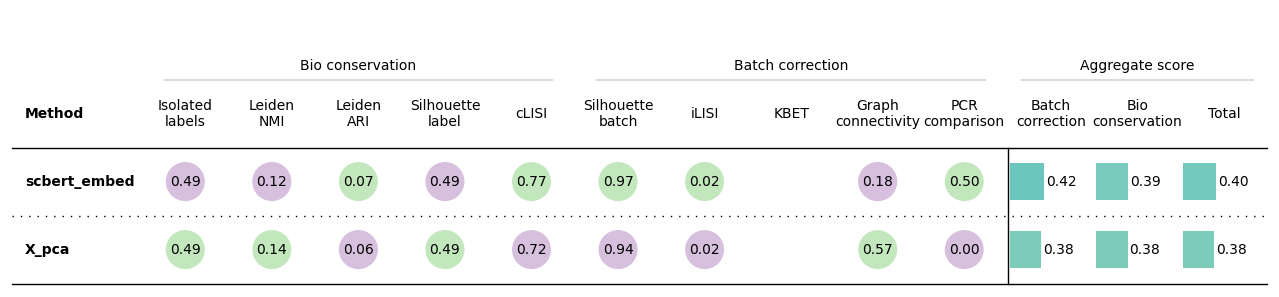


--- scIB Benchmark Results ---
| Embedding    | Isolated labels    | Leiden NMI          | Leiden ARI          | Silhouette label    | cLISI              | Silhouette batch   | iLISI                | KBET             | Graph connectivity   | PCR comparison     | Batch correction    | Bio conservation    | Total               |
|:-------------|:-------------------|:--------------------|:--------------------|:--------------------|:-------------------|:-------------------|:---------------------|:-----------------|:---------------------|:-------------------|:--------------------|:--------------------|:--------------------|
| scbert_embed | 0.4898548424243927 | 0.12233415859944168 | 0.0700703720973302  | 0.49315086007118225 | 0.7710611820220947 | 0.9671977162361145 | 0.023294193670153618 | nan              | 0.17825291289541034  | 0.4987868146218465 | 0.4168829135468328  | 0.3892942830428883  | 0.40032973524446613 |
| X_pca        | 0.4928588569164276 | 0.13501292719923252 | 0.062474641585

In [62]:
# --- scIB Benchmark ---

if not bench_cfg['run_benchmark']:
    print("Skipping scIB benchmark as configured.")
elif not bench_cfg['embedding_keys']:
    print("Skipping scIB benchmark: No embedding keys specified in config.")
else:
    # Verify keys exist in adata and config
    label_key = data_keys_cfg['ground_truth_key'] # Use same ground truth as eval
    batch_key = data_keys_cfg['batch_key']
    embedding_keys = [k for k in bench_cfg['embedding_keys'] if k in adata.obsm]
    missing_keys = [k for k in bench_cfg['embedding_keys'] if k not in adata.obsm]

    if not embedding_keys:
        print("Skipping scIB benchmark: None of the specified embedding keys found in adata.obsm.")
    elif label_key not in adata.obs:
        print(f"Skipping scIB benchmark: Label key '{label_key}' not found in adata.obs.")
    elif batch_key not in adata.obs:
        print(f"Skipping scIB benchmark: Batch key '{batch_key}' not found in adata.obs.")
    else:
        if missing_keys:
            print(f"Warning: The following embedding keys specified for scIB were not found and will be skipped: {missing_keys}")

        print(f"Benchmarking embeddings: {embedding_keys}")
        print(f"Using label key: '{label_key}' and batch key: '{batch_key}'")

        # Define metric configurations based on YAML
        bio_conservation = BioConservation(
            nmi_ari_cluster_labels_kmeans=bench_cfg['bio_conservation_kmeans'],
            nmi_ari_cluster_labels_leiden=bench_cfg['bio_conservation_leiden']
            # Add other BioConservation metrics if needed
        )
        batch_correction = BatchCorrection(
            pcr_comparison=bench_cfg['batch_correction_pcr']
            # Add other BatchCorrection metrics if needed
        )

        # Run Benchmarker
        bm = Benchmarker(
            adata,
            batch_key=batch_key,
            label_key=label_key,
            embedding_obsm_keys=embedding_keys,
            # Pre-computed neighbors and UMAP can be used if available, but Benchmarker recalculates as needed
            # neighbors_obsm_keys = {'X_pca': 'neighbors', 'X_umap': 'neighbors_umap'}, # Example if needed
            n_jobs=bench_cfg['n_jobs'],
            bio_conservation_metrics=bio_conservation,
            batch_correction_metrics=batch_correction
        )

        bm.benchmark()

        # Plot and save results
        print("Plotting scIB results table...")
        results_table_path = os.path.join(output_cfg['benchmarking_output_dir'], "scib_results_table")
        bm.plot_results_table(min_max_scale=False, save_dir=results_table_path) # Saves plot and csv

        # You can access the results dataframe directly:
        results_df = bm.get_results(min_max_scale=False)
        print("\n--- scIB Benchmark Results ---")
        print(results_df.to_markdown(floatfmt=".4f"))
        results_csv_path = os.path.join(output_cfg['benchmarking_output_dir'], 'scib_results_summary.csv')
        results_df.to_csv(results_csv_path)
        print(f"scIB results summary saved to {results_csv_path}")

# Final Save of Processed AnnData

In [63]:
# --- Final Save of Processed AnnData ---

final_adata_path = os.path.join(output_cfg['adata_clustered_dir'], output_cfg['adata_clustered_filename'])
print(f"Saving AnnData with embeddings, clusters, and other results to: {final_adata_path}")

# Ensure the directory exists
os.makedirs(os.path.dirname(final_adata_path), exist_ok=True)

try:
    adata.write(final_adata_path, compression='gzip')
    print("Final AnnData saved successfully.")
except Exception as e:
    warnings.warn(f"Error saving final AnnData: {e}")

Saving AnnData with embeddings, clusters, and other results to: results/clustered_data/sn_tumor_cells_embed_cluster.h5ad
Final AnnData saved successfully.
